In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip
/kaggle/input/lending-club-20072020q1/LCDataDictionary.xlsx


In [2]:
file_path = "/kaggle/input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip"

# import polars as pl

# df = pl.read_csv(file_path)

df = pd.read_csv(file_path, low_memory=False)
df.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


## ETL

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [4]:
df.columns.tolist()

['Unnamed: 0',
 'id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_join

In [30]:
df1 = pd.read_excel('/kaggle/input/lending-club-20072020q1/LCDataDictionary.xlsx')
list(df.itertuples(index=False, name=None))

KeyboardInterrupt: 

In [6]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: count, dtype: int64

In [7]:
default_map = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,

    'Charged Off': 1,
    'Default': 1,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1
}

df['default'] = df['loan_status'].map(default_map)

In [8]:
df_clean = df.dropna(subset=['default']).copy()

In [9]:
df_clean['default'] = df_clean['default'].astype(int)

In [10]:
# Row counts
print("Rows before ETL:", df.shape[0])
print("Rows after ETL:", df_clean.shape[0])

# Default distribution
df_clean['default'].value_counts(normalize=True)

Rows before ETL: 2925493
Rows after ETL: 1882386


default
0    0.796739
1    0.203261
Name: proportion, dtype: float64

In [11]:
analysis_cols = [
    'loan_amnt',
    'term',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'pub_rec',
    'collections_12_mths_ex_med',
    'fico_range_low',
    'fico_range_high',
    'issue_d',
    'grade',
    'default'
]

df_clean = df_clean[analysis_cols]

In [12]:
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1882386 entries, 0 to 2925492
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float64
 1   term                        object 
 2   int_rate                    object 
 3   installment                 float64
 4   annual_inc                  float64
 5   dti                         float64
 6   delinq_2yrs                 float64
 7   pub_rec                     float64
 8   collections_12_mths_ex_med  float64
 9   fico_range_low              float64
 10  fico_range_high             float64
 11  issue_d                     object 
 12  grade                       object 
 13  default                     int64  
dtypes: float64(9), int64(1), object(4)
memory usage: 215.4+ MB


,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,pub_rec,collections_12_mths_ex_med,fico_range_low,fico_range_high,issue_d,grade,default
0,5000.0,36 months,10.65%,162.87,24000.0,27.65,0.0,0.0,0.0,735.0,739.0,Dec-2011,B,0
1,2500.0,60 months,15.27%,59.83,30000.0,1.00,0.0,0.0,0.0,740.0,744.0,Dec-2011,C,1
2,2400.0,36 months,15.96%,84.33,12252.0,8.72,0.0,0.0,0.0,735.0,739.0,Dec-2011,C,0
3,10000.0,36 months,13.49%,339.31,49200.0,20.00,0.0,0.0,0.0,690.0,694.0,Dec-2011,C,0
4,3000.0,60 months,12.69%,67.79,80000.0,17.94,0.0,0.0,0.0,695.0,699.0,Dec-2011,B,0


## EDA

### DTI vs default

In [13]:
df_clean['dti_band'] = pd.cut(
    df_clean['dti'],
    bins=[0, 30, 40, 50, 100],
    labels=['Low (<30%)', 'Moderate (30–40%)', 'High (40–50%)', 'Very High (>50%)']
)

In [14]:
df_clean.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,pub_rec,collections_12_mths_ex_med,fico_range_low,fico_range_high,issue_d,grade,default,dti_band
0,5000.0,36 months,10.65%,162.87,24000.0,27.65,0.0,0.0,0.0,735.0,739.0,Dec-2011,B,0,Low (<30%)
1,2500.0,60 months,15.27%,59.83,30000.0,1.00,0.0,0.0,0.0,740.0,744.0,Dec-2011,C,1,Low (<30%)
2,2400.0,36 months,15.96%,84.33,12252.0,8.72,0.0,0.0,0.0,735.0,739.0,Dec-2011,C,0,Low (<30%)
3,10000.0,36 months,13.49%,339.31,49200.0,20.00,0.0,0.0,0.0,690.0,694.0,Dec-2011,C,0,Low (<30%)
4,3000.0,60 months,12.69%,67.79,80000.0,17.94,0.0,0.0,0.0,695.0,699.0,Dec-2011,B,0,Low (<30%)


In [15]:
dti_default = (
    df_clean
    .groupby('dti_band')['default']
    .mean()
    .reset_index()
    .rename(columns={'default': 'default_rate'})
)

dti_default

/tmp/ipykernel_55/276948173.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('dti_band')['default']


,dti_band,default_rate
0,Low (<30%),0.194114
1,Moderate (30–40%),0.278985
2,High (40–50%),0.317164
3,Very High (>50%),0.327807


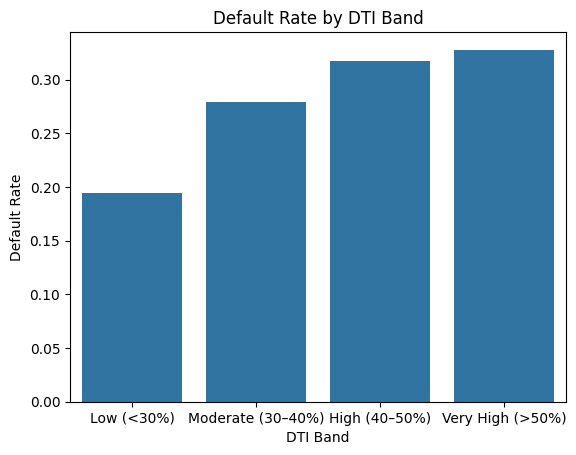

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=dti_default,
    x='dti_band',
    y='default_rate'
)

plt.title('Default Rate by DTI Band')
plt.ylabel('Default Rate')
plt.xlabel('DTI Band')
plt.show()

### FICO vs default

In [17]:
df_clean['fico_score'] = (
    df_clean['fico_range_low'] + df_clean['fico_range_high']
) / 2

df_clean['fico_band'] = pd.cut(
    df_clean['fico_score'],
    bins=[300, 600, 650, 700, 750, 900],
    labels=[
        'Very High Risk (<600)',
        'High Risk (600–650)',
        'Medium Risk (650–700)',
        'Low Risk (700–750)',
        'Very Low Risk (>750)'
    ]
)



df_clean.head()


,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,pub_rec,collections_12_mths_ex_med,fico_range_low,fico_range_high,issue_d,grade,default,dti_band,fico_score,fico_band
0,5000.0,36 months,10.65%,162.87,24000.0,27.65,0.0,0.0,0.0,735.0,739.0,Dec-2011,B,0,Low (<30%),737.0,Low Risk (700–750)
1,2500.0,60 months,15.27%,59.83,30000.0,1.00,0.0,0.0,0.0,740.0,744.0,Dec-2011,C,1,Low (<30%),742.0,Low Risk (700–750)
2,2400.0,36 months,15.96%,84.33,12252.0,8.72,0.0,0.0,0.0,735.0,739.0,Dec-2011,C,0,Low (<30%),737.0,Low Risk (700–750)
3,10000.0,36 months,13.49%,339.31,49200.0,20.00,0.0,0.0,0.0,690.0,694.0,Dec-2011,C,0,Low (<30%),692.0,Medium Risk (650–700)
4,3000.0,60 months,12.69%,67.79,80000.0,17.94,0.0,0.0,0.0,695.0,699.0,Dec-2011,B,0,Low (<30%),697.0,Medium Risk (650–700)


In [18]:
fico_default = (
    df_clean
    .groupby('fico_band')['default']
    .mean()
    .reset_index()
    .rename(columns={'default': 'default_rate'})
)

fico_default

/tmp/ipykernel_55/291986964.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fico_band')['default']


,fico_band,default_rate
0,Very High Risk (<600),NaN
1,High Risk (600–650),0.320346
2,Medium Risk (650–700),0.237076
3,Low Risk (700–750),0.168265
4,Very Low Risk (>750),0.103770


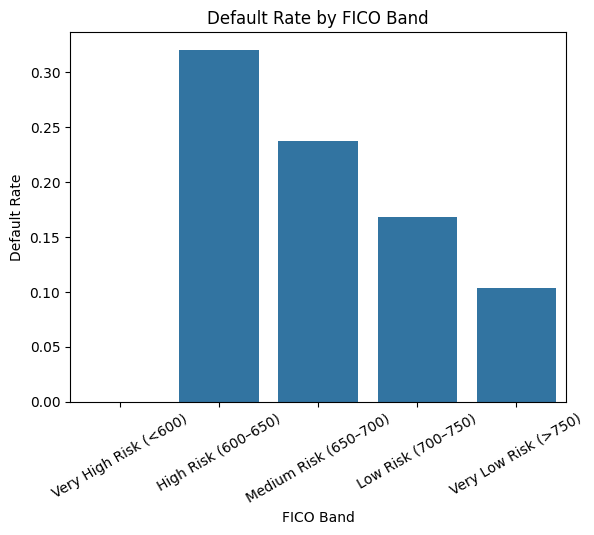

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=fico_default,
    x='fico_band',
    y='default_rate'
)

plt.title('Default Rate by FICO Band')
plt.ylabel('Default Rate')
plt.xlabel('FICO Band')
plt.xticks(rotation=30)
plt.show()

### FICO x DTI

In [20]:
df_clean[['dti_band', 'fico_band']].dropna().head()

,dti_band,fico_band
0,Low (<30%),Low Risk (700–750)
1,Low (<30%),Low Risk (700–750)
2,Low (<30%),Low Risk (700–750)
3,Low (<30%),Medium Risk (650–700)
4,Low (<30%),Medium Risk (650–700)


In [21]:
interaction_pd = (
    df_clean
    .groupby(['dti_band', 'fico_band'])['default']
    .mean()
    .reset_index()
    .rename(columns={'default': 'default_rate'})
)

interaction_pd

/tmp/ipykernel_55/677218343.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['dti_band', 'fico_band'])['default']


,dti_band,fico_band,default_rate
0,Low (<30%),Very High Risk (<600),NaN
1,Low (<30%),High Risk (600–650),0.311404
2,Low (<30%),Medium Risk (650–700),0.227680
3,Low (<30%),Low Risk (700–750),0.159064
4,Low (<30%),Very Low Risk (>750),0.098238
5,Moderate (30–40%),Very High Risk (<600),NaN
6,Moderate (30–40%),High Risk (600–650),NaN
7,Moderate (30–40%),Medium Risk (650–700),0.314417
8,Moderate (30–40%),Low Risk (700–750),0.236563
9,Moderate (30–40%),Very Low Risk (>750),0.163709


In [22]:
interaction_pivot = interaction_pd.pivot(
    index='dti_band',
    columns='fico_band',
    values='default_rate'
)

interaction_pivot

fico_band,Very High Risk (<600),High Risk (600–650),Medium Risk (650–700),Low Risk (700–750),Very Low Risk (>750)
dti_band,,,,,
Low (<30%),NaN,0.311404,0.227680,0.159064,0.098238
Moderate (30–40%),NaN,NaN,0.314417,0.236563,0.163709
High (40–50%),NaN,NaN,0.350999,0.291667,0.201729
Very High (>50%),NaN,NaN,0.375895,0.305012,0.186557


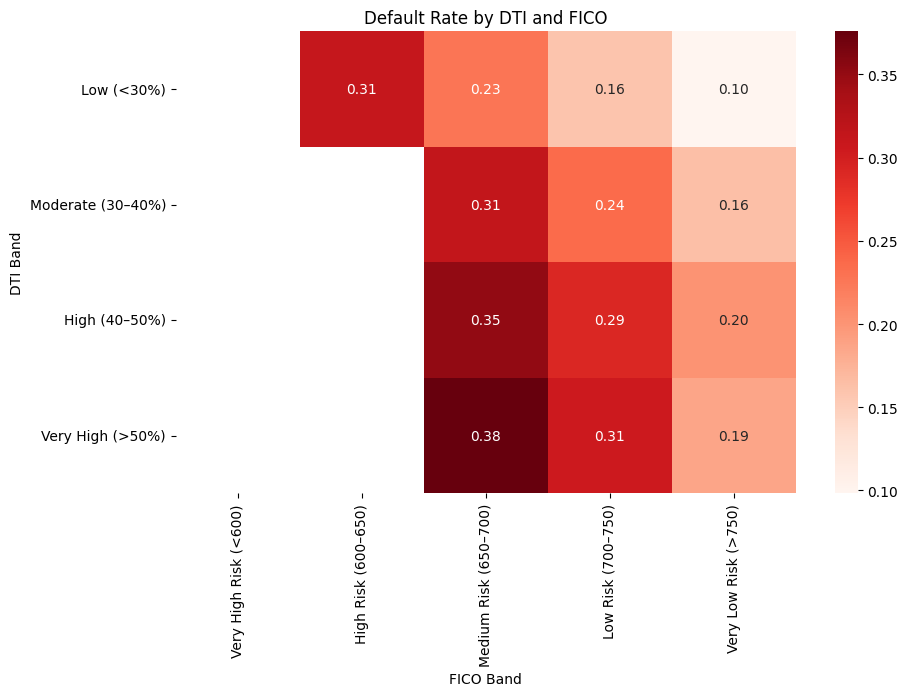

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    interaction_pivot,
    annot=True,
    fmt=".2f",
    cmap="Reds"
)

plt.title('Default Rate by DTI and FICO')
plt.xlabel('FICO Band')
plt.ylabel('DTI Band')
plt.show()


## Segmentation

In [24]:
df_clean['severe_repayment_issue'] = (
    (df_clean['delinq_2yrs'] >= 3) |
    (df_clean['pub_rec'] > 0) |
    (df_clean['collections_12_mths_ex_med'] > 0)
)

In [25]:
df_clean['risk_segment'] = 'Unassigned'


# very high risk
df_clean.loc[
    (df_clean['dti'] > 50) |
    (df_clean['severe_repayment_issue']),
    'risk_segment'
] = 'Very High Risk'


#high risk
df_clean.loc[
    (df_clean['risk_segment'] == 'Unassigned') &
    (
        ((df_clean['dti'] > 40) & (df_clean['dti'] <= 50)) |
        ((df_clean['fico_score'] >= 600) & (df_clean['fico_score'] < 650))
    ),
    'risk_segment'
] = 'High Risk'


#medium risk
df_clean.loc[
    (df_clean['risk_segment'] == 'Unassigned') &
    (df_clean['dti'] > 30) & (df_clean['dti'] <= 40) &
    (df_clean['fico_score'] >= 650) & (df_clean['fico_score'] < 700),
    'risk_segment'
] = 'Medium Risk'


#low risk
df_clean.loc[
    (df_clean['risk_segment'] == 'Unassigned') &
    (df_clean['dti'] <= 30) &
    (df_clean['fico_score'] >= 700) & (df_clean['fico_score'] < 750),
    'risk_segment'
] = 'Low Risk'


#very low risk
df_clean.loc[
    (df_clean['risk_segment'] == 'Unassigned') &
    (df_clean['dti'] <= 30) &
    (df_clean['fico_score'] >= 750),
    'risk_segment'
] = 'Very Low Risk'


#remaining unassigned to Medium Risk
df_clean.loc[
    df_clean['risk_segment'] == 'Unassigned',
    'risk_segment'
] = 'Medium Risk'

In [26]:
df_clean['risk_segment'].value_counts()

risk_segment
Medium Risk       862543
Low Risk          476485
Very High Risk    384785
Very Low Risk     151426
High Risk           7147
Name: count, dtype: int64

In [27]:
df_clean.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,pub_rec,collections_12_mths_ex_med,fico_range_low,fico_range_high,issue_d,grade,default,dti_band,fico_score,fico_band,severe_repayment_issue,risk_segment
0,5000.0,36 months,10.65%,162.87,24000.0,27.65,0.0,0.0,0.0,735.0,739.0,Dec-2011,B,0,Low (<30%),737.0,Low Risk (700–750),False,Low Risk
1,2500.0,60 months,15.27%,59.83,30000.0,1.00,0.0,0.0,0.0,740.0,744.0,Dec-2011,C,1,Low (<30%),742.0,Low Risk (700–750),False,Low Risk
2,2400.0,36 months,15.96%,84.33,12252.0,8.72,0.0,0.0,0.0,735.0,739.0,Dec-2011,C,0,Low (<30%),737.0,Low Risk (700–750),False,Low Risk
3,10000.0,36 months,13.49%,339.31,49200.0,20.00,0.0,0.0,0.0,690.0,694.0,Dec-2011,C,0,Low (<30%),692.0,Medium Risk (650–700),False,Medium Risk
4,3000.0,60 months,12.69%,67.79,80000.0,17.94,0.0,0.0,0.0,695.0,699.0,Dec-2011,B,0,Low (<30%),697.0,Medium Risk (650–700),False,Medium Risk


In [28]:
df_clean.groupby('risk_segment')['default'].mean().sort_values(ascending=False)

risk_segment
High Risk         0.306982
Medium Risk       0.234491
Very High Risk    0.230848
Low Risk          0.156181
Very Low Risk     0.098510
Name: default, dtype: float64

In [29]:
df_clean.to_csv(
    'credit_portfolio.csv',
    index=False
)